In [1]:
import csv
import datetime
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from os.path import expanduser

dparser = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
df = pd.read_csv(
    'in_lang_cleaned_extended.tsv',
    header=None,
    names = ['uuid', 'lang', 'aid', 'published', 'category', 'journal_ref', 'bibitem_str'],
    sep='\t',
    parse_dates=['published'],
    date_parser=dparser,
    low_memory=False,
    quoting=csv.QUOTE_NONE
)

In [2]:
# Overall distribution across disciplines

disc_map = {  # see: https://arxiv.org/category_taxonomy
    'math': 'math',
    'cond-mat': 'phys',
    'math-ph': 'phys',
    'physics': 'phys',
    'cs': 'cs',
    'hep-th': 'phys',
    'nlin': 'phys',
    'gr-qc': 'phys',
    'hep-ph': 'phys',
    'astro-ph': 'phys',
    'quant-ph': 'phys',
    'nucl-th': 'phys',
    'q-fin': 'other',
    'hep-ex': 'phys',
    'stat': 'other',
    'nucl-ex': 'phys',
    'q-alg': 'math',
    'q-bio': 'other',
    'solv-int': 'phys',
    'chao-dyn': 'phys',
    'hep-lat': 'phys',
    'funct-an': 'math',
    'patt-sol': 'phys',
    'dg-ga': 'other',
    'alg-geom': 'math',
    'cmp-lg': 'cs',
    'adap-org': 'phys',
    'econ': 'other',
    'eess': 'other',
    'acc-phys': 'phys',
    'comp-gas': 'cs'
}
unarXive_total_counts = {
    'math': 237422,
    'cs': 111694,
    'phys': 662894,
    'other': 31116
}
coarse_disc_counts = df['category'].apply(lambda x: disc_map[x.split('.')[0]]).value_counts()
for disc, total in unarXive_total_counts.items():
    absolute_count = coarse_disc_counts[disc]
    of_total = absolute_count/total
    print('{}: {} ({:.4f})'.format(disc, absolute_count, of_total))

math: 14660 (0.0617)
cs: 1638 (0.0147)
phys: 16450 (0.0248)
other: 542 (0.0174)


In [3]:
# Load arXiv metadata

fos_map = {
    'physics': 'phys',
    'math': 'math',
    'cs': 'cs',
    'eess': 'other',
    'econ': 'other'
}

dparser2 = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d')
df_ameta = pd.read_csv(
    'aid_to_cat_n_date.csv',
    sep=',',
    parse_dates=['date'],
    date_parser=dparser2,
    low_memory=False,
    quoting=csv.QUOTE_NONE
)
df_ameta.fos = df_ameta.fos.apply(lambda x: fos_map[x])

In [4]:
# Absolute and relative number of E-to-nE references/docs w/ E-to-nE refs per year per discipline

# # use number of E-to-nE references
# in_lang_distribution = df.groupby(
#     [
#         df['published'].dt.year,
#         df['category'].apply(lambda x: disc_map[x.split('.')[0]])
#     ]
# ).size().unstack(fill_value=0)

# # use number of docs w/ E-to-nE refs
in_lang_distribution = df.groupby(
    [
        df['published'].dt.year,
        df['category'].apply(lambda x: disc_map[x.split('.')[0]])
    ]
).agg({'aid': pd.Series.nunique}).unstack(fill_value=0)['aid']
print('--- absolute ---')
print(in_lang_distribution)
total_distribution = df_ameta.groupby(
    [
        df_ameta.date.dt.year,
        df_ameta.fos
    ]
).size().unstack(fill_value=0)

discs = ['phys', 'math', 'cs']
phys_cross_ling_ratios = pd.Series(dtype=float, name='phys')
math_cross_ling_ratios = pd.Series(dtype=float, name='math')
cs_cross_ling_ratios = pd.Series(dtype=float, name='cs')
cross_ling_ratios = {
    'phys': phys_cross_ling_ratios,
    'math': math_cross_ling_ratios,
    'cs': cs_cross_ling_ratios
}

print('--- relative --- ')
print('\t'.join([''] + [f'{d}                ' for d in discs]))
for year, row in in_lang_distribution.iterrows():
    if year < 1993 or year > 2018:
        continue
    vals = []
    for disc in discs:
        vals.append('{}/{} = {:.6f}'.format(
            row[disc],
            total_distribution[disc][year],
            row[disc]/total_distribution[disc][year]
        ))
        cross_ling_ratios[disc].at[year] = row[disc]/total_distribution[disc][year]
    print('\t'.join([str(year)] + vals))

--- absolute ---
category    cs  math  other  phys
published                        
1992         0     0      0    18
1993         0     2      0    62
1994         1     8      0    74
1995         1    24      1   113
1996         3    22      5   135
1997         1    18      5   189
1998         2    33      0   260
1999         4    46      0   297
2000         7    62      0   378
2001        12    70      0   318
2002         6    86      0   359
2003         7   101      1   381
2004         9   141      2   387
2005        10   169      2   410
2006        24   217      4   435
2007        28   274      6   407
2008        37   315     15   363
2009        39   383     17   456
2010        57   467     15   435
2011        58   518      9   438
2012        88   550     17   444
2013        94   659     26   464
2014       105   698     24   447
2015        96   710     24   470
2016        87   755     22   398
2017       118   750     33   435
2018       116   758     44   3

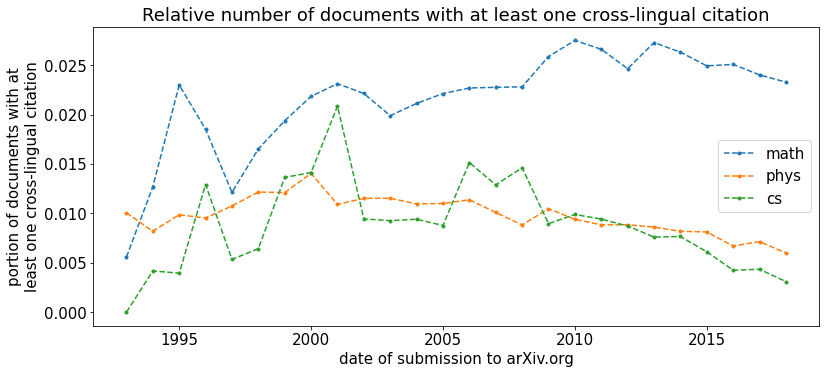

In [5]:
df_paper_cross_ling_ratios = pd.concat(
    [math_cross_ling_ratios,
    phys_cross_ling_ratios,
    cs_cross_ling_ratios], axis=1
)

# --- font setup (not working)
# run in venv: from matplotlib.font_manager import _rebuild; _rebuild()
# # matplotlib.use('Agg')                         # LaTeX mode
# libertine_path = expanduser('/usr/share/fonts/opentype/linux-libertine/LinLibertine_R.otf')
# libertine_prop = matplotlib.font_manager.FontProperties(fname=libertine_path)
# matplotlib.rcParams['font.family'] = libertine_prop.get_name()
# # matplotlib.rcParams['text.usetex'] = True     # LaTeX mode
# --- /font setup

matplotlib.rcParams['font.size'] = 15
ax = df_paper_cross_ling_ratios.plot(
    kind='line',
    marker='.',
    style='--',
    figsize=(13,5.5),
    title='Relative number of documents with at least one cross-lingual citation')
ax.set_xlabel("date of submission to arXiv.org")
ax.set_ylabel("portion of documents with at\nleast one cross-lingual citation")
ax.figure.savefig('relative_number_of_papers_with_cross_ling_cit_by_year_and_category.pdf', dpi=300)

In [6]:
# Number of cross-lingual citations relative to number of submissions, by year

arxiv_monthly_df = pd.read_csv('arXiv_monthly_submissions.csv')
total_submissions_per_year = {}
for i, row in arxiv_monthly_df.iterrows():
    year, month = row.month.split('-')
    if int(year) == df['published'].max().year and int(month) > df['published'].max().month:
        continue
    if year not in total_submissions_per_year:
        total_submissions_per_year[year] = 0
    total_submissions_per_year[year] += row.submissions
relative_submissions_per_year = {}
for year, absolute_refs in df['published'].dt.year.value_counts().to_dict().items():
    of_total = absolute_refs/total_submissions_per_year[str(year)]
    relative_submissions_per_year[year] = of_total
    #print('{}: {} ({:.4f})'.format(year, absolute_refs, of_total))

for year in range(df['published'].min().year, df['published'].max().year):
    print('{}: {:.4f}'.format(year, relative_submissions_per_year[year]))
    # TODO plot
    # TODO: look at this per discipline & per language

1992: 0.0086
1993: 0.0215
1994: 0.0153
1995: 0.0202
1996: 0.0193
1997: 0.0194
1998: 0.0237
1999: 0.0251
2000: 0.0296
2001: 0.0237
2002: 0.0233
2003: 0.0244
2004: 0.0234
2005: 0.0247
2006: 0.0271
2007: 0.0226
2008: 0.0224
2009: 0.0244
2010: 0.0240
2011: 0.0236
2012: 0.0237
2013: 0.0244
2014: 0.0233
2015: 0.0222
2016: 0.0188
2017: 0.0194
2018: 0.0178


In [7]:
# Number of *documents* with cross-lingual citations relative to number of total submissions, by year

for year, row in df.groupby(df['published'].dt.year).agg({'aid': pd.Series.nunique}).iterrows():
    num_docs_total = total_submissions_per_year[str(year)]
    num_docs_abs = row.aid
    print('{}: {:.4f}'.format(year, num_docs_abs/num_docs_total))

1992: 0.0055
1993: 0.0095
1994: 0.0082
1995: 0.0107
1996: 0.0104
1997: 0.0109
1998: 0.0122
1999: 0.0125
2000: 0.0146
2001: 0.0120
2002: 0.0125
2003: 0.0124
2004: 0.0123
2005: 0.0126
2006: 0.0135
2007: 0.0129
2008: 0.0124
2009: 0.0140
2010: 0.0139
2011: 0.0134
2012: 0.0130
2013: 0.0134
2014: 0.0131
2015: 0.0123
2016: 0.0111
2017: 0.0108
2018: 0.0093
2019: 0.0083


In [8]:
# Variability of languages within reference sections of a single papers

df.groupby(
    'aid'
).agg(
    {'lang': [pd.Series.nunique]}
)['lang']['nunique'].value_counts()

1    17223
2      864
3       76
4        7
5        1
Name: nunique, dtype: int64

In [9]:
# Papers citing 4 or more different languages

for aid, lang_list in df.groupby('aid')['lang'].apply(set).items():
    if len(lang_list) > 3:
        # print('    * [arXiv:{0}](https://arxiv.org/abs/{0}): {1}'.format(aid, ', '.join(list(lang_list))))
        print('{}: {}'.format(aid, ', '.join(list(lang_list))))

1002.1356: french, spanish, german, russian
1011.4253: italian, german, french, russian
1103.4166: italian, german, french, russian
1309.5620: italian, french, german, russian
1406.6143: french, polish, italian, german, russian
1408.5287: french, esperanto, italian, german
1511.03821: serbian, japanese, bulgarian, russian
1512.08268: chinese, german, russian, hungarian


In [10]:
# Most common language pairs per document

import itertools
from operator import itemgetter

lang_pair_dict = {}
for aid, lang_list in df.groupby('aid')['lang'].apply(set).items():
    if len(lang_list) > 1:
        for pair in itertools.combinations(lang_list, 2):
            pair_key = '+'.join(sorted(list(pair)))
            if pair_key not in lang_pair_dict:
                lang_pair_dict[pair_key] = 0
            lang_pair_dict[pair_key] += 1
            
sorted(lang_pair_dict.items(), key=itemgetter(1), reverse=True)

[('russian+ukrainian', 277),
 ('german+russian', 166),
 ('french+russian', 135),
 ('french+german', 68),
 ('chinese+russian', 59),
 ('polish+russian', 50),
 ('japanese+russian', 35),
 ('english+russian', 28),
 ('hungarian+russian', 24),
 ('romanian+russian', 20),
 ('bulgarian+russian', 20),
 ('italian+russian', 18),
 ('danish+russian', 17),
 ('german+italian', 14),
 ('french+italian', 12),
 ('czech+russian', 10),
 ('russian+spanish', 9),
 ('german+ukrainian', 9),
 ('chinese+english', 8),
 ('french+polish', 7),
 ('czech+hungarian', 7),
 ('german+hungarian', 7),
 ('russian+slovak', 7),
 ('russian+serbian', 7),
 ('french+ukrainian', 6),
 ('chinese+german', 5),
 ('french+spanish', 5),
 ('danish+polish', 5),
 ('chinese+japanese', 5),
 ('bulgarian+chinese', 4),
 ('chinese+polish', 4),
 ('hungarian+polish', 4),
 ('english+german', 4),
 ('english+japanese', 3),
 ('french+slovak', 3),
 ('german+japanese', 3),
 ('german+polish', 3),
 ('armenian+russian', 3),
 ('french+hungarian', 2),
 ('finnish+

In [11]:
# Overall language counts (number of references & number of citing docs)
df.groupby(
    'lang'
).agg(
    {'aid': [pd.Series.count, pd.Series.nunique]}
)['aid'].sort_values(
    'nunique', ascending=False
)

,count,nunique
lang,,
russian,23922,12304
chinese,2351,1582
japanese,1843,1397
german,1244,965
french,931,719
ukrainian,876,444
polish,421,335
hungarian,306,283
italian,209,191


In [12]:
for disc in ['phys', 'math', 'cs', 'other']:
    print(f'**{disc}**  ')
    print(df.loc[df['category'].apply(lambda x: disc_map[x.split('.')[0]])==disc].groupby(
        'lang'
    ).agg(
        {'aid': [pd.Series.count, pd.Series.nunique]}
    )['aid'].sort_values(
        'nunique', ascending=False
    )[:5].to_markdown())
    print()

**phys**  
| lang     |   count |   nunique |
|:---------|--------:|----------:|
| russian  |   12147 |      6206 |
| japanese |     835 |       683 |
| chinese  |     959 |       637 |
| german   |     741 |       585 |
| french   |     437 |       327 |

**math**  
| lang     |   count |   nunique |
|:---------|--------:|----------:|
| russian  |   10713 |      5484 |
| chinese  |    1127 |       796 |
| japanese |     676 |       534 |
| french   |     382 |       305 |
| german   |     393 |       292 |

**cs**  
| lang     |   count |   nunique |
|:---------|--------:|----------:|
| russian  |     851 |       512 |
| japanese |     247 |       133 |
| chinese  |     170 |       107 |
| german   |      79 |        68 |
| french   |      72 |        64 |

**other**  
| lang     |   count |   nunique |
|:---------|--------:|----------:|
| russian  |     211 |       102 |
| japanese |      85 |        47 |
| chinese  |      95 |        42 |
| french   |      40 |        23 |
| german 

In [17]:
df_coarsecat = df.copy()
df_coarsecat.category = df_coarsecat.category.apply(lambda x: disc_map[x.split('.')[0]])

# df_coarsecat[(df_coarsecat.published.dt.year == 2000) & (df_coarsecat.category == 'cs')]

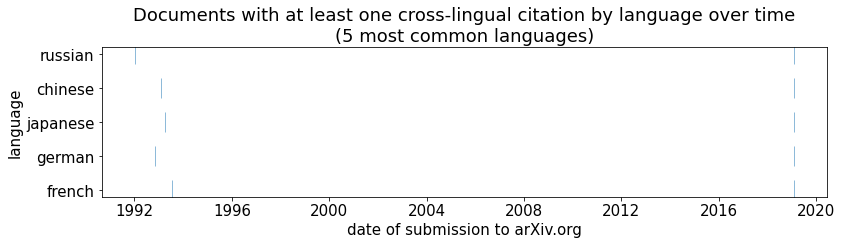

In [18]:
langs_across_time = df_coarsecat[['published', 'lang']].set_index('published')
top_n = 5
topX = langs_across_time[langs_across_time.lang != 'english'].lang.value_counts()[:top_n].to_dict().keys()
lang_rows = []
for lang in list(topX)[::-1]:
    lang_rows.append(langs_across_time[langs_across_time.lang == lang])
langs_across_time = pd.concat(lang_rows)
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(13,.55*top_n))
plt.plot(
    langs_across_time[langs_across_time.lang.isin(topX)].index,
    langs_across_time[langs_across_time.lang.isin(topX)].lang,
    marker='|',
    alpha=.5,
    lw=0,
    ms=20,
    
)
plt.yticks(list(topX))
plt.title(f'Documents with at least one cross-lingual citation by language over time\n({top_n} most common languages)')
plt.xlabel('date of submission to arXiv.org')
plt.ylabel('language')
# plt.savefig('cross_ling_citations_by_lang_across_time.pdf', dpi=300)
# plt.savefig('cross_ling_citations_by_lang_across_time.png', dpi=300)

# TODO: mby distinguish disciplines by color?

# for creating png markers w/ PDF scaffold
# lang_rows.append(langs_across_time[langs_across_time.lang == lang].sort_index()[:1])
# lang_rows.append(langs_across_time[langs_across_time.lang == lang].sort_index()[-1:])
plt.savefig('cross_ling_citations_by_lang_across_time_skeleton.pdf', dpi=300)

In [21]:
print(langs_across_time.sort_index()[:1])
print(langs_across_time.sort_index()[-1:])

                        lang
published                   
1992-01-02 19:06:00  russian
                         lang
published                    
2019-01-31 12:36:59  japanese


In [78]:
# Analyze relative number of documents across languages

total_submission_numbers = df_ameta.groupby(df_ameta.date.dt.year).agg({'aid': pd.Series.nunique}).to_dict()['aid']
rel_lang_counts = {}
for tup in df.groupby([df.lang, df.published.dt.year]).agg({'aid': pd.Series.nunique}).iterrows():
    lang, year = tup[0]
    n_docs = int(tup[1])
    if year == 2019:
        # only January
        continue
    if lang not in rel_lang_counts:
        rel_lang_counts[lang] = {}
    rel_lang_counts[lang][year] = n_docs/total_submission_numbers[year]
for lang, dic in rel_lang_counts.items():
    for year in range(1992, 2019):
        if year not in dic:
            rel_lang_counts[lang][year] = 0

In [94]:
# generate lots'a plots to get an overview

# for lang, dic in rel_lang_counts.items():
#     years = pd.Series([year for year in range(1992, 2019)], name='year')
#     rel_counts = pd.Series([rel_lang_counts[lang][year] for year in range(1992, 2019)], name='rc')
#     df_rlc = pd.concat([years, rel_counts], axis=1).set_index('year')
#     rlc_plot = df_rlc.plot()
#     rlc_plot.figure.savefig(f'rel_{lang}_across_time.png', dpi=300)
#     plt.close()

In [101]:
# visualize general top 5

years = pd.Series([year for year in range(1992, 2019)], name='year')
rel_counts_ru = pd.Series([rel_lang_counts['russian'][year] for year in range(1992, 2019)], name='russian')
rel_counts_zh = pd.Series([rel_lang_counts['chinese'][year] for year in range(1992, 2019)], name='chinese')
rel_counts_ja = pd.Series([rel_lang_counts['japanese'][year] for year in range(1992, 2019)], name='japanese')
rel_counts_de = pd.Series([rel_lang_counts['german'][year] for year in range(1992, 2019)], name='german')
rel_counts_fr = pd.Series([rel_lang_counts['french'][year] for year in range(1992, 2019)], name='french')
df_rlc = pd.concat([
    years,
    rel_counts_ru,
    rel_counts_zh,
    rel_counts_ja,
    rel_counts_de,
    rel_counts_fr
], axis=1).set_index('year')

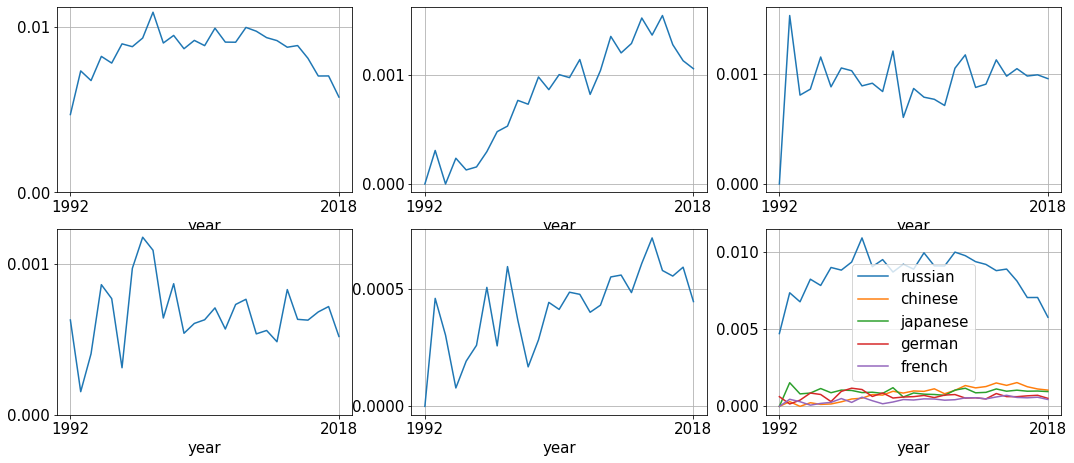

In [139]:
matplotlib.rcParams['font.size'] = 15
# ax = df_refsec_cross_ling_crosssecs.plot(
#     kind='bar',
#     # marker='.',
#     # style='--',
#     figsize=(13,5.5),
#     title='Relative number of documents per discipline by "cross-linguality" of reference section'
# )
# ax.set_xlabel('percentage rage of "cross-lignuality" of reference section')
# ax.set_ylabel("portion of documents")
# ax.figure.savefig('cross_ling_ratio_distribution_across_disciplines_w_min_size_3.pdf', dpi=300)


fig, axes = plt.subplots(nrows=2, ncols=3)

df_rlc.russian.plot(ax=axes[0,0], figsize=(18,7.5), xticks=[1992, 2018], yticks=[0, 0.01], grid=True)
df_rlc.chinese.plot(ax=axes[0,1], xticks=[1992, 2018], yticks=[0, 0.001], grid=True)
df_rlc.japanese.plot(ax=axes[0,2], xticks=[1992, 2018], yticks=[0, 0.001], grid=True)
df_rlc.german.plot(ax=axes[1,0], xticks=[1992, 2018], yticks=[0, 0.001], grid=True)
df_rlc.french.plot(ax=axes[1,1], xticks=[1992, 2018], yticks=[0, 0.0005], grid=True)
df_rlc.plot(ax=axes[1,2], xticks=[1992, 2018], yticks=[0, 0.005, 0.01], grid=True)
plt.savefig('relative_language_counts_across_time.pdf', dpi=300)